Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLev

C:\Users\rabik\AppData\Local\Temp\ipykernel_39880\3429189681.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Attrition', data=df, palette='coolwarm')


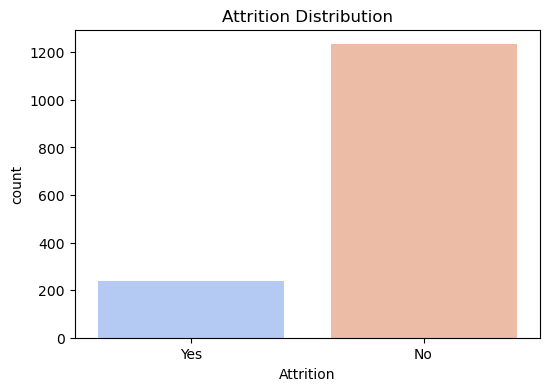

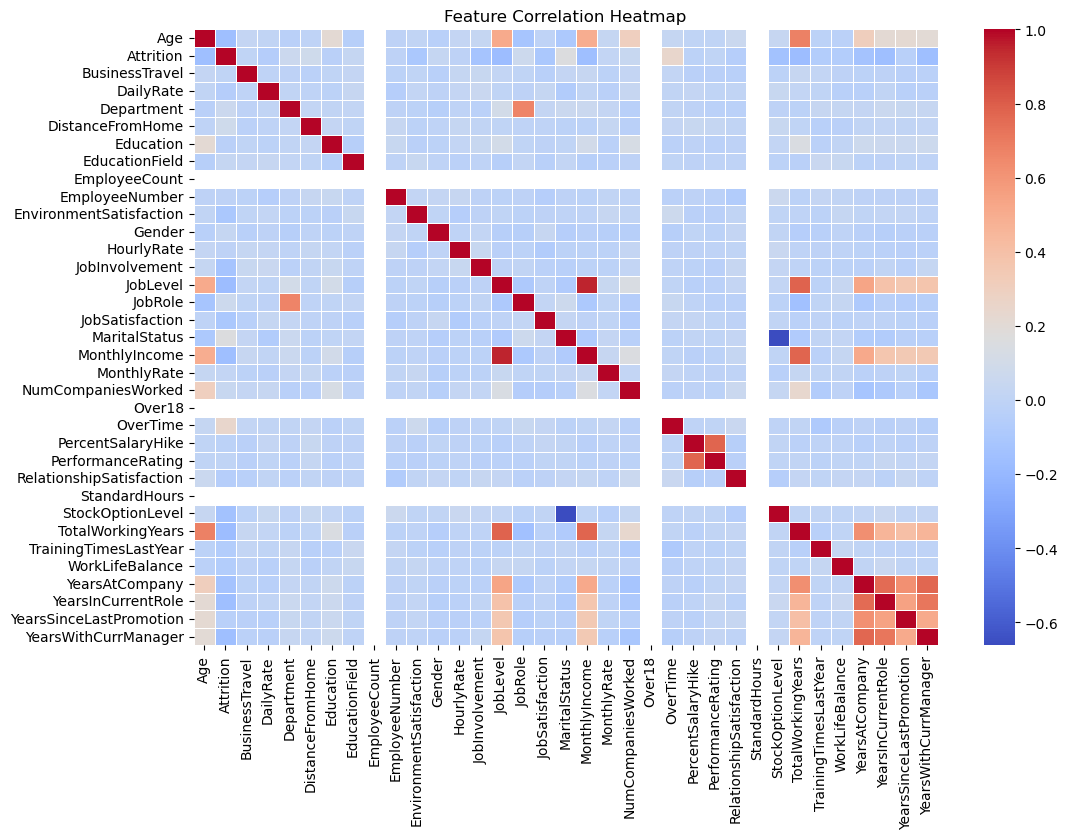

Best Logistic Regression C: {'C': 1}
Threshold 0.10 -> Recall: 0.97, Precision: 0.52, Accuracy: 0.65
Threshold 0.15 -> Recall: 0.96, Precision: 0.58, Accuracy: 0.72
Threshold 0.20 -> Recall: 0.93, Precision: 0.62, Accuracy: 0.75
Threshold 0.25 -> Recall: 0.91, Precision: 0.66, Accuracy: 0.79
Threshold 0.30 -> Recall: 0.87, Precision: 0.68, Accuracy: 0.80
Threshold 0.35 -> Recall: 0.81, Precision: 0.70, Accuracy: 0.80
Threshold 0.40 -> Recall: 0.79, Precision: 0.73, Accuracy: 0.81
Threshold 0.45 -> Recall: 0.74, Precision: 0.73, Accuracy: 0.80


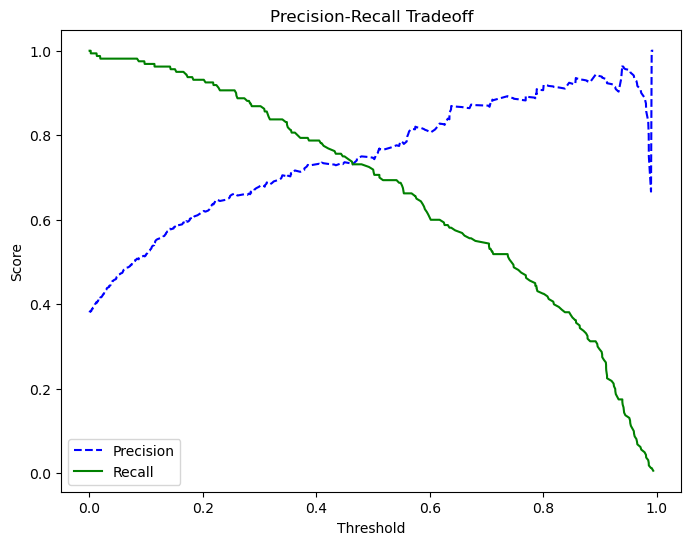


Best Threshold: 0.45000000000000007

Final Model Performance:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84       260
           1       0.73      0.74      0.74       160

    accuracy                           0.80       420
   macro avg       0.79      0.79      0.79       420
weighted avg       0.80      0.80      0.80       420

Final Model Accuracy: 0.8
Best Model and Scaler saved successfully!


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, recall_score, precision_score, accuracy_score
import joblib

# Step 1: Load Dataset
file_path = "C:/Users/rabik/OneDrive/Desktop/Data Science for Business Package/1. Human Resources Data/Human_Resources.csv"
df = pd.read_csv(file_path)

# Step 2: Data Exploration (EDA)
print("Dataset Overview:")
df.info()
print(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Attrition distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Attrition', data=df, palette='coolwarm')
plt.title("Attrition Distribution")
plt.show()

# Encode categorical variables
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Step 3: Data Preprocessing
X = df.drop(columns=['Attrition'])
y = df['Attrition']

# Apply SMOTE with controlled oversampling
smote = SMOTE(sampling_strategy=0.7, random_state=42)  # Only balance to 70% rather than fully equal
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardizing numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Train Models
# Logistic Regression with Hyperparameter Tuning
log_reg = LogisticRegression()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
log_reg_cv = GridSearchCV(log_reg, param_grid, scoring='recall', cv=5)
log_reg_cv.fit(X_train, y_train)
print(f"Best Logistic Regression C: {log_reg_cv.best_params_}")

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predict probabilities
y_probs_log = log_reg_cv.predict_proba(X_test)[:, 1]
y_probs_rf = rf_model.predict_proba(X_test)[:, 1]

# Step 5: Optimize Threshold for Better Recall
thresholds = np.arange(0.1, 0.5, 0.05)  # Testing thresholds from 0.1 to 0.5
best_threshold, best_recall, best_precision = 0.2, 0, 0

for t in thresholds:
    y_pred_t = (y_probs_log > t).astype(int)
    recall_t = recall_score(y_test, y_pred_t)
    precision_t = precision_score(y_test, y_pred_t)
    accuracy_t = accuracy_score(y_test, y_pred_t)
    print(f"Threshold {t:.2f} -> Recall: {recall_t:.2f}, Precision: {precision_t:.2f}, Accuracy: {accuracy_t:.2f}")
    
    if recall_t >= 0.65 and precision_t > best_precision:
        best_threshold = t
        best_recall = recall_t
        best_precision = precision_t

# Precision-Recall Curve Visualization
precisions, recalls, pr_thresholds = precision_recall_curve(y_test, y_probs_log)
plt.figure(figsize=(8, 6))
plt.plot(pr_thresholds, precisions[:-1], label="Precision", linestyle="--", color="blue")
plt.plot(pr_thresholds, recalls[:-1], label="Recall", color="green")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision-Recall Tradeoff")
plt.show()

# Choose the best threshold dynamically
y_pred_best = (y_probs_log > best_threshold).astype(int)
print(f"\nBest Threshold: {best_threshold}")
print("\nFinal Model Performance:")
print(classification_report(y_test, y_pred_best))
print("Final Model Accuracy:", accuracy_score(y_test, y_pred_best))

# Step 6: Save the Best Model
best_model = log_reg_cv if best_precision > 0.3 else rf_model  # Choose the best between Logistic and RF
joblib.dump(best_model, "best_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("Best Model and Scaler saved successfully!")
